# Conversion of Image Data from SimpleITK to Numpy and VTK 

## Imports

In [1]:
import numpy
import vtk
import SimpleITK
from vtk.util.numpy_support import numpy_to_vtk
import matplotlib.pyplot as plt
%matplotlib inline

---

## Helper-functions

In [2]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

We're gonna use this function to embed a still image of a VTK render

In [3]:
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

We're gonna use these functions to quickly 'convert' between SimpleITK and VTK data types

In [4]:
dctITKtoVTK = {SimpleITK.sitkInt8: vtk.VTK_TYPE_INT8,
               SimpleITK.sitkInt16: vtk.VTK_TYPE_INT16,
               SimpleITK.sitkInt32: vtk.VTK_TYPE_INT32,
               SimpleITK.sitkInt64: vtk.VTK_TYPE_INT64,
               SimpleITK.sitkUInt8: vtk.VTK_TYPE_UINT8,
               SimpleITK.sitkUInt16: vtk.VTK_TYPE_UINT16,
               SimpleITK.sitkUInt32: vtk.VTK_TYPE_UINT32,
               SimpleITK.sitkUInt64: vtk.VTK_TYPE_UINT64,
               SimpleITK.sitkFloat32: vtk.VTK_TYPE_FLOAT32,
               SimpleITK.sitkFloat64: vtk.VTK_TYPE_FLOAT64}
dctVTKtoITK = dict(zip(dctITKtoVTK.values(), 
                       dctITKtoVTK.keys()))

def convertTypeITKtoVTK(typeITK):
    if typeITK in dctITKtoVTK:
        return dctITKtoVTK[typeITK]
    else:
        raise ValueError("Type not supported")

def convertTypeVTKtoITK(typeVTK):
    if typeVTK in dctVTKtoITK:
        return dctVTKtoITK[typeVTK]
    else:
        raise ValueError("Type not supported")

---

## Options

In [5]:
filenameMyHead = "./MyHead.nii"

Read in data with SimpleITK

In [6]:
imgMyHead_SimpleITK = SimpleITK.ReadImage(filenameMyHead)

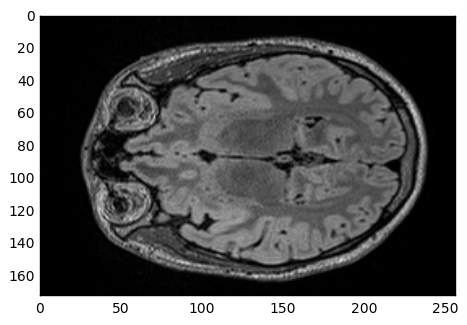

In [7]:
sitk_show(imgMyHead_SimpleITK[:,100,:])

Convert `SimpleITK.Image` object to a `numpy.ndarray`

In [8]:
imgMyHead_NumPy = numpy.ravel(SimpleITK.GetArrayFromImage(imgMyHead_SimpleITK), order='C')

In [9]:
info_vec = vtk.vtkInformationVector()
info_vec.SetNumberOfInformationObjects(1)
info_obj = info_vec.GetInformationObject(0)
print info_obj
vtk.vtkDataObject.SetPointDataActiveScalarInfo(info_obj,
                                              convertTypeITKtoVTK(imgMyHead_SimpleITK.GetPixelID()),
                                              imgMyHead_SimpleITK.GetNumberOfComponentsPerPixel())
print info_obj, info_vec

vtkInformation (0x120b74610)
  Debug: Off
  Modified Time: 43
  Reference Count: 2
  Registered Events: (none)


vtkInformation (0x120b74610)
  Debug: Off
  Modified Time: 45
  Reference Count: 2
  Registered Events: (none)
  POINT_DATA_VECTOR: vtkInformationVector(0x1210cfb20)

 vtkInformationVector (0x12100f2a0)
  Debug: Off
  Modified Time: 41
  Reference Count: 1
  Registered Events: (none)
  Number of Information Objects: 1
  Information Objects:
    vtkInformation(0x120b74610):
      Debug: Off
      Modified Time: 45
      Reference Count: 2
      Registered Events: (none)
      POINT_DATA_VECTOR: vtkInformationVector(0x1210cfb20)




Convert `numpy.ndarray` to a `vtk.vtkImageData` object

In [10]:
imgMyHead_VTK = vtk.vtkImageData()
imgMyHead_VTK.SetSpacing(imgMyHead_SimpleITK.GetSpacing())
imgMyHead_VTK.SetOrigin(imgMyHead_SimpleITK.GetOrigin())
imgMyHead_VTK.SetDimensions(imgMyHead_SimpleITK.GetSize())
# imgMyHead_VTK.SetScalarType(convertTypeITKtoVTK(imgMyHead_SimpleITK.GetPixelID()), info_obj)
imgMyHead_VTK.AllocateScalars(convertTypeITKtoVTK(imgMyHead_SimpleITK.GetPixelID()),
                             imgMyHead_SimpleITK.GetNumberOfComponentsPerPixel())
# imgMyHead_VTK.SetNumberOfScalarComponents(imgMyHead_SimpleITK.GetNumberOfComponentsPerPixel())

In [11]:
imgMyHead_NumPyToVTK = numpy_to_vtk(imgMyHead_NumPy, 
                                    deep=True, 
                                    array_type=convertTypeITKtoVTK(imgMyHead_SimpleITK.GetPixelID()))

imgMyHead_VTK.GetPointData().SetScalars(imgMyHead_NumPyToVTK)

0